In [124]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Read in the training csv

In [84]:
train = pd.read_csv('../data/training_data.csv', low_memory=False)

In [37]:
train = train.drop(columns=['Unnamed: 0','EventTimeStamp','EquipmentID.1','EquipmentID.2'],axis = 1)

In [50]:
train['EquipmentID']

0          1327
1          1327
2          1327
3          1327
4          1327
          ...  
468951      310
468952      310
468953    R1762
468954    R1762
468955    R1764
Name: EquipmentID, Length: 468956, dtype: object

# Cleaning up predictors

In [45]:
class GroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self,strategy='mean'):
        self.strategy = strategy
    def fit(self, df):
        imputer ={}
        if self.strategy == 'mean':
            self.overall_ = df.mean()
        if self.strategy == 'median':
            self.overall_ = df.median()
        if self.strategy == 'mode':
            self.overall_ = df.mode().iloc[0]
        for truck, columns in df.groupby('EquipmentID'):
            if self.strategy == 'mean':
                imputer[truck] = columns.mean()
            if self.strategy == 'median':
                imputer[truck] = columns.median()
            if self.strategy == 'mode':
                imputer[truck] = columns.mode().iloc[0] #iloc is in case there's more than one mode
        self.imputer_ = imputer
        return self
    def transform(self,df):
        new_df = df.copy()
        for truck in self.imputer_:
            val = self.imputer_[truck]
            new_df.loc[new_df.EquipmentID == truck] = new_df.loc[new_df.EquipmentID == truck].fillna(val)
        new_df = new_df.fillna(self.overall_)
        return new_df            

In [46]:
gi_mean = GroupImputer(strategy='mean')
gi_median = GroupImputer(strategy='median')
gi_mode = GroupImputer(strategy='mode')

In [52]:
mean_col = ['BarometricPressure','EngineLoad','Speed','EquipmentID']
median_col = ['EngineOilPressure','EngineOilTemperature','FuelLevel','IntakeManifoldTemperature','TurboBoostPressure','EngineCoolantTemperature','FuelRate','EquipmentID']
mode_col = ['AcceleratorPedal','EngineRpm','FuelTemperature','SwitchedBatteryVoltage','IgnStatus','DistanceLtd','FuelLtd','EngineTimeLtd','EquipmentID']

In [53]:
ct = ColumnTransformer(transformers=[
    ('mean',gi_mean,mean_col),
    ('median',gi_median,median_col),
    ('mode',gi_mode,mode_col)
], remainder = 'passthrough')

In [54]:
ct.fit(train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('mean', GroupImputer(),
                                 ['BarometricPressure', 'EngineLoad', 'Speed',
                                  'EquipmentID']),
                                ('median', GroupImputer(strategy='median'),
                                 ['EngineOilPressure', 'EngineOilTemperature',
                                  'FuelLevel', 'IntakeManifoldTemperature',
                                  'TurboBoostPressure',
                                  'EngineCoolantTemperature', 'FuelRate',
                                  'EquipmentID']),
                                ('mode', GroupImputer(strategy='mode'),
                                 ['AcceleratorPedal', 'EngineRpm',
                                  'FuelTemperature', 'SwitchedBatteryVoltage',
                                  'IgnStatus', 'DistanceLtd', 'FuelLtd',
                                  'EngineTimeLtd', 'EquipmentID'])]

In [57]:
test = pd.read_csv('../data/testing_data.csv', low_memory=False)

In [58]:
test = test.drop(columns=['Unnamed: 0','EventTimeStamp'],axis = 1)

In [55]:
train.shape[1]

1065

In [59]:
test.shape[1]

1065

In [65]:
# [x for x in train.columns if x not in test.columns]
test = test[train.columns] #rearranges columns in test to match that of train

In [71]:
imputed_cols = mean_col + median_col + mode_col
remaining_cols = [x for x in train.columns if x not in imputed_cols]

In [101]:
test2 = ct.transform(test)

In [77]:
list(test2.columns)

['BarometricPressure',
 'EngineLoad',
 'Speed',
 'EquipmentID',
 'EngineOilPressure',
 'EngineOilTemperature',
 'FuelLevel',
 'IntakeManifoldTemperature',
 'TurboBoostPressure',
 'EngineCoolantTemperature',
 'FuelRate',
 'EquipmentID',
 'AcceleratorPedal',
 'EngineRpm',
 'FuelTemperature',
 'SwitchedBatteryVoltage',
 'IgnStatus',
 'DistanceLtd',
 'FuelLtd',
 'EngineTimeLtd',
 'EquipmentID',
 'FaultId',
 'ecuMake',
 'active',
 'derate_soon',
 '0-0',
 '100-1',
 '100-18',
 '100-2',
 '100-3',
 '100-4',
 '100-5',
 '101-0',
 '101-14',
 '101-15',
 '101-16',
 '101-2',
 '101-3',
 '101-4',
 '101-5',
 '102-10',
 '102-14',
 '102-15',
 '102-16',
 '102-17',
 '102-18',
 '102-2',
 '102-20',
 '102-3',
 '102-31',
 '102-4',
 '102-5',
 '1023-5',
 '1024-0',
 '1028-9',
 '103-1',
 '103-10',
 '103-16',
 '103-18',
 '103-4',
 '103-7',
 '103-9',
 '1043-2',
 '1045-2',
 '1045-7',
 '105-0',
 '105-17',
 '105-18',
 '105-2',
 '105-3',
 '105-5',
 '1056-2',
 '1056-4',
 '1056-5',
 '1059-2',
 '1067-11',
 '1067-2',
 '1067-

In [102]:

test2 = pd.DataFrame(test2, columns=imputed_cols + remaining_cols)

In [103]:
column_numbers = [x for x in range(test2.shape[1])]  # list of columns' integer indices

column_numbers.remove(3)
column_numbers.remove(11)
test2 = test2.iloc[:, column_numbers] #return all columns except the 3,11th column


In [4]:
#ecuMake has some missing data, will have to adjust that as well
train['ecuMake'].unique()

array(['CMMNS', 'unknown', nan, '??MNS', 'BNDWS', 'VOLVO', 'PACCR',
       '?????', '?MMNS', '?ACCR', 'PCAR', '?CAR', '?????MX', '?NDWS',
       '????S', '????R', 'EATON', '?ATON', '?????MX16U13D13'],
      dtype=object)

`?MMNS` -> `CMMNS`
`??MNS` -> `CMMNS`
`?ACCR` -> `PACCR`
`????R` -> `PACCR`
`???CR` -> `PACCR`
`?ATON` -> `EATON`
`?NDWS` -> `BNDWS`
`??DWS` -> `BNDWS`
`?CAR` -> `PCAR`
`???R` -> `PCAR`
`????S` -> `unknown` (Could be CMMNS or BNDWS)
`?????` -> `unknown` (Could be anything)

In [5]:
train['ecuMake'] = train['ecuMake'].replace('?MMNS','CMMNS')
train['ecuMake'] = train['ecuMake'].replace('??MNS','CMMNS')
train['ecuMake'] = train['ecuMake'].replace('?CAR','PCAR')
train['ecuMake'] = train['ecuMake'].replace('???R','PCAR')
train['ecuMake'] = train['ecuMake'].replace('?ACCR','PACCR')
train['ecuMake'] = train['ecuMake'].replace('????R','PACCR')
train['ecuMake'] = train['ecuMake'].replace('???CR','PACCR')
train['ecuMake'] = train['ecuMake'].replace('?ATON','EATON')
train['ecuMake'] = train['ecuMake'].replace('?NDWS','BNDWS')
train['ecuMake'] = train['ecuMake'].replace('??DWS','BNDWS')


In [6]:
# train = train[(train['ecuMake'] == 'CMMNS') | (train['ecuMake'] == 'PCAR') | (train['ecuMake'] == 'PACCR') | 
#               (train['ecuMake'] == 'EATON') | (train['ecuMake'] == 'BNDWS') | (train['ecuMake'] == 'VOLVO')]

In [7]:
#dummy variables for the string/object data types
train = pd.get_dummies(train, columns = ['ecuMake', 'IgnStatus','EquipmentID'])

In [8]:
# Predictors
X_train = train.drop(columns = 'derate_soon')
#Target Variable
y_train = train['derate_soon']

# Logistic Regression 
* due to the large number of columns, I'm using the l1 penalty in place of lasso because of this from Stack Overflow:
<center>'The Lasso optimizes a least-square problem with a L1 penalty. By definition you can't optimize a logistic function with the Lasso.'</center>
   

In [10]:
log = LogisticRegression(penalty='l1', solver='liblinear')

In [11]:
log.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [104]:
test2['ecuMake'] = test2['ecuMake'].replace('?MMNS','CMMNS')
test2['ecuMake'] = test2['ecuMake'].replace('??MNS','CMMNS')
test2['ecuMake'] = test2['ecuMake'].replace('?CAR','PCAR')
test2['ecuMake'] = test2['ecuMake'].replace('???R','PCAR')
test2['ecuMake'] = test2['ecuMake'].replace('?ACCR','PACCR')
test2['ecuMake'] = test2['ecuMake'].replace('????R','PACCR')
test2['ecuMake'] = test2['ecuMake'].replace('???CR','PACCR')
test2['ecuMake'] = test2['ecuMake'].replace('?ATON','EATON')
test2['ecuMake'] = test2['ecuMake'].replace('?NDWS','BNDWS')
test2['ecuMake'] = test2['ecuMake'].replace('??DWS','BNDWS')

# test2 = test2[(test2['ecuMake'] == 'CMMNS') | (test2['ecuMake'] == 'PCAR') | (test2['ecuMake'] == 'PACCR') | 
#               (test2['ecuMake'] == 'EATON') | (test2['ecuMake'] == 'BNDWS') | (test2['ecuMake'] == 'VOLVO')]


test2 = pd.get_dummies(test2, columns = ['ecuMake', 'IgnStatus','EquipmentID'])

In [105]:
X_test = test2.drop(columns = 'derate_soon')

In [109]:
#michael doesn't like this at all:
for col in [x for x in X_train.columns if x not in X_test.columns]:
    X_test[col] = 0

X_test = X_test[X_train.columns]

In [35]:
# ct.fit(train)

ValueError: A given column is not a column of the dataframe

In [42]:
from joblib import dump, load
dump(log, 'log_reg.joblib') 


['log_reg.joblib']

In [110]:
y_pred = log.predict(X_test)

In [111]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [112]:
y_test = test2['derate_soon']

In [120]:
# y_test.value_counts(dropna = False)
pd.Series(y_pred).value_counts(dropna=False)

False    117235
True          6
dtype: int64

In [121]:
accuracy_score(y_test==True,y_pred==True)

0.9976629336153735

In [123]:
confusion_matrix(y_test==True,y_pred==True)

array([[116967,      6],
       [   268,      0]], dtype=int64)

In [83]:
[x for x in X_train.columns if x not in X_test.columns]

['EquipmentID_1338',
 'EquipmentID_1344',
 'EquipmentID_1418',
 'EquipmentID_1429',
 'EquipmentID_1492',
 'EquipmentID_1510',
 'EquipmentID_1525',
 'EquipmentID_1526',
 'EquipmentID_1534',
 'EquipmentID_1535',
 'EquipmentID_1571',
 'EquipmentID_2119',
 'EquipmentID_2239',
 'EquipmentID_2271',
 'EquipmentID_2274',
 'EquipmentID_2275',
 'EquipmentID_2288',
 'EquipmentID_2289',
 'EquipmentID_2297',
 'EquipmentID_2298',
 'EquipmentID_2303',
 'EquipmentID_2304',
 'EquipmentID_2311',
 'EquipmentID_2312',
 'EquipmentID_2316',
 'EquipmentID_2322',
 'EquipmentID_2327',
 'EquipmentID_2330',
 'EquipmentID_2331',
 'EquipmentID_2337',
 'EquipmentID_2339',
 'EquipmentID_2342',
 'EquipmentID_2343',
 'EquipmentID_2346',
 'EquipmentID_2350',
 'EquipmentID_2358',
 'EquipmentID_2359',
 'EquipmentID_2360',
 'EquipmentID_2361',
 'EquipmentID_2366',
 'EquipmentID_2367',
 'EquipmentID_2371',
 'EquipmentID_2377',
 'EquipmentID_2380',
 'EquipmentID_2381']

In [108]:
train.loc[train.EquipmentID == '2298']

,Unnamed: 0,BarometricPressure,EngineLoad,Speed,EquipmentID,EngineOilPressure,EngineOilTemperature,FuelLevel,IntakeManifoldTemperature,TurboBoostPressure,...,96-3,96-4,96-9,97-15,97-16,97-3,97-4,976-9,98-18,98-5
458177,458177,14.5725,23.0,0.0,2298,41.18,75.48125,92.8,66.2,0.0,...,0,0,0,0,0,0,0,0,0,0


# SGD: similar to Logistic Regression but faster
* classweights=balanced

In [127]:
sgd = SGDClassifier(class_weight='balanced',penalty='l1', loss = 'log')

In [129]:
sgd.fit(X_train,y_train)

SGDClassifier(class_weight='balanced', loss='log', penalty='l1')

In [130]:
y_pred = sgd.predict(X_test)

In [133]:
accuracy_score(y_test==True,y_pred==True)

0.003292363592941036

In [134]:
confusion_matrix(y_test==True,y_pred==True)

array([[   118, 116855],
       [     0,    268]], dtype=int64)

In [135]:
log.coef_

array([[ 0.05090528, -0.00839287,  0.01079255, ...,  0.        ,
         0.        ,  0.        ]])

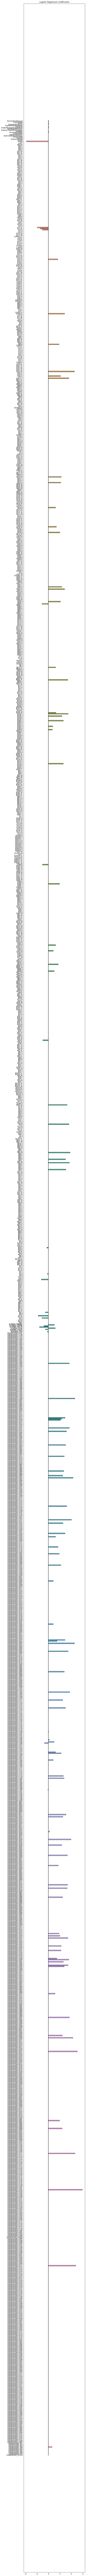

In [137]:
fig, ax = plt.subplots(figsize = (7,300))
sns.barplot(x = log.coef_[0], y = list(X_test.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')

ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);